<a href="https://colab.research.google.com/github/anwishn/ESAA_OB_23-1/blob/main/0331_hw_%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

# 1. Introduction

* clustering의 대표 적용 사례
  + customers segmentation
  + image segmentation
  + documents clusterisation

* 많은 clustering 알고리즘
  + Hierarchical : 하위 집합에 항목이 하나만 포함될 때까지 반복적으로 더 작은 하위 집합으로 분할. 분할/합병 과정을 위한 종결 조건 정의해야해
  + Partitional : 주어진 기준에 따라 데이터 집합을 여러 하위 집합으로 나눈다. 일부 알고리즘의 경우(K-평균) 클러스터 수를 선행 값으로 정의해야 하며 일부는(DBSCAN) 그렇지 않는다

# 2. Reading data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.4.4
numpy version: 1.22.4
seaborn version: 0.12.2


In [2]:
mall_data = pd.read_csv('/content/drive/MyDrive/data/Mall_Customers.csv')
print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [3]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
143,144,Female,32,76,87
183,184,Female,29,98,88
122,123,Female,40,69,58
50,51,Female,49,42,52
173,174,Male,36,87,92
103,104,Male,26,62,55
138,139,Male,19,74,10
36,37,Female,42,34,17
179,180,Male,35,93,90
197,198,Male,32,126,74


In [4]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


* 5 columns
  + Customer ID : numerical. unique customer number. integer
  + Gender : categorical. binary(Male/Female)
  + Age : numerical. integer
  + Annual Income : numerical. integer
  + Spending Score : numerical. integer

In [5]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# 3. Exploratory Data Analysis

## 3.1 Distributions

<ipython-input-6-b444f70e1579>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-6-b444f70e1579>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_age, bins=age_bins, kd

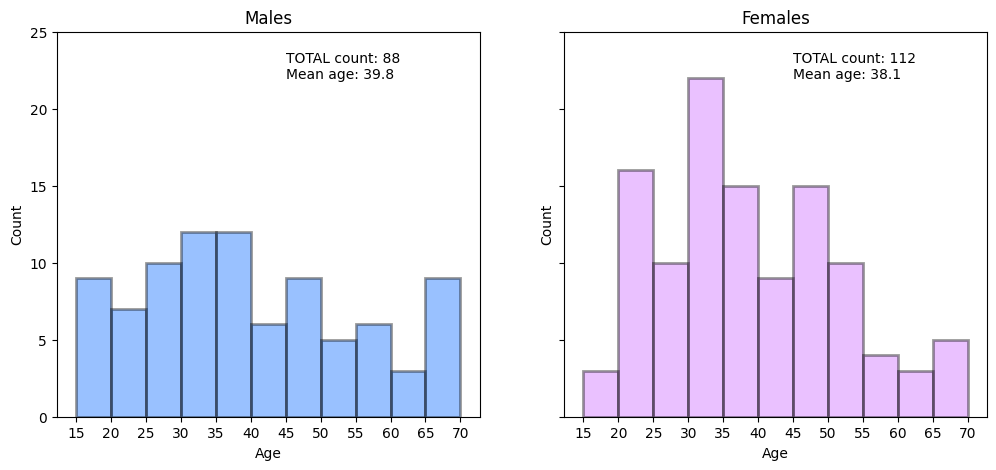

In [6]:
males_age = mall_data[mall_data['Gender']=='Male']['Age']  # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age']  # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

In [7]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


=> 남성 고객의 평균 연령 > 여성 고객의 평균 연령. 남성 연령의 분포는 여성보다 더 균일. 가장 큰 연령대는 30-35세

=> Kolgomorov-Smirnov 검정은 이 두 그릅 간의 차이가 통계적으로 유의하지 않음을 보여줌

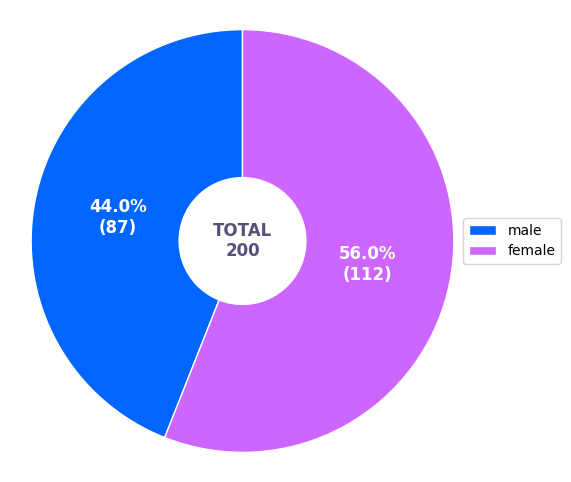

In [8]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

=> 여성 고객 > 남성 고객. 여성 고객은 전체 고객의 56%

<ipython-input-9-0d86fc4a2b23>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-9-0d86fc4a2b23>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_income, bins=my_bins

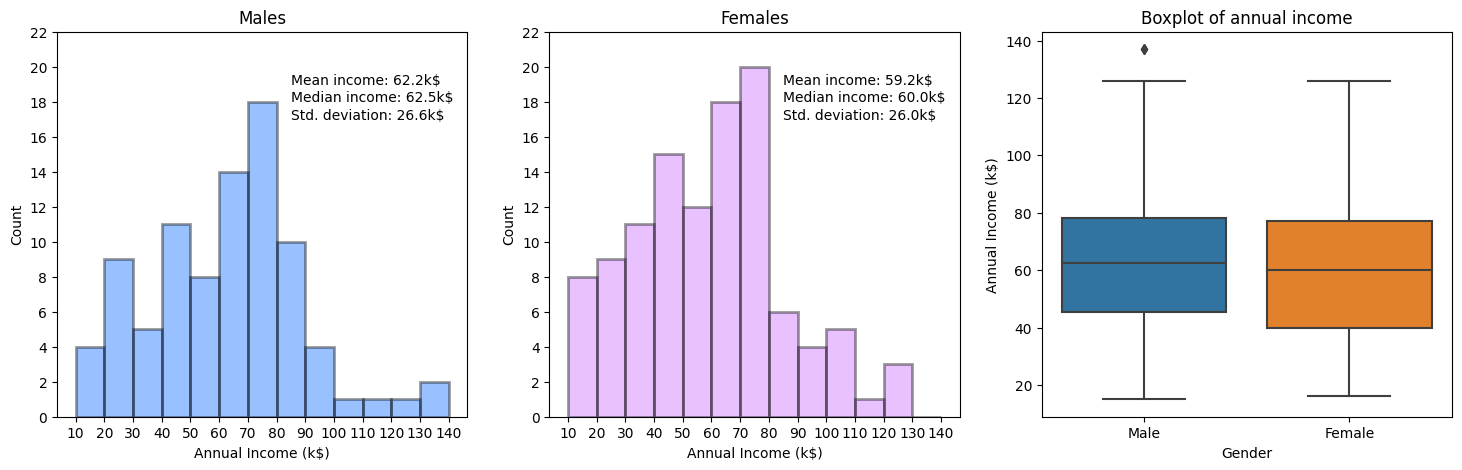

In [9]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [10]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


=> 남성의 평균 소득 > 여성의 평균 소득. 남성 고객의 중위 소득 > 여성 고객의 중위 소득. 표준편차는 두 그릅 모두 비슷. 

=> 연간 수입이 약 140,000달러인 남성 그룹에 한 명의 특이한 사람 있어 -> K-S 검정을 통해 이 두 그룹이 통계적으로 다르지 않음을 알 수 있음

<ipython-input-11-95f80557e0ae>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-11-95f80557e0ae>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_spending, 

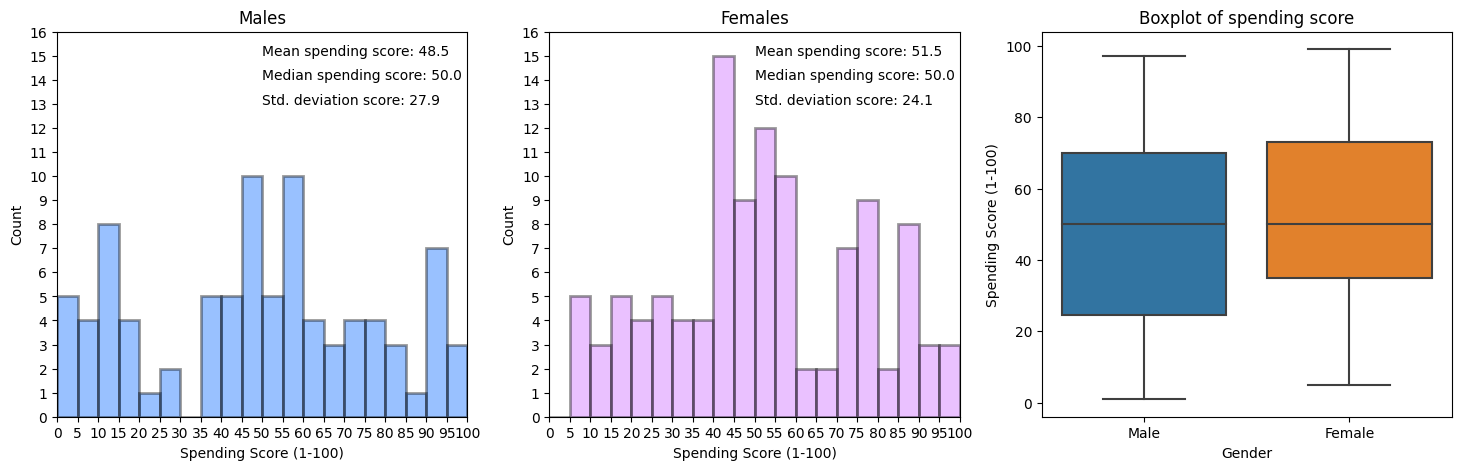

In [11]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [12]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


=> 여성의 평균 지출 점수 > 남성의 평균 지출 점수. K-S 검정 p-값은 귀무 가설을 기각할 증거가 없다는 것을 나타내지만, 이전의 비교처럼 증거가 강력하지는 않음

In [13]:
# 모든 연령대의 중위소득 계산
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

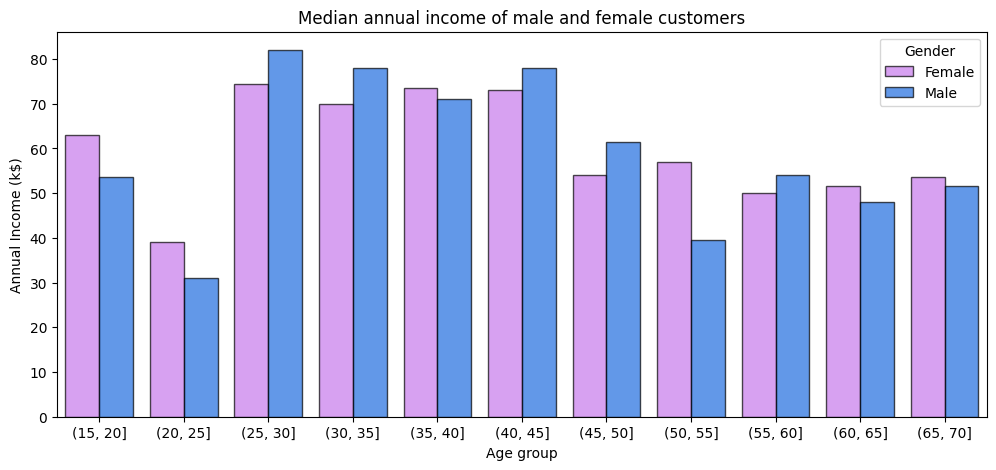

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

=> 가장 부유한 고객이 25-45세. 여성과 남성의 가장 큰 차이는 25-30세(남성이 더 부유함)와 50-55세(여성이 더 부유함) 연령대에서 볼 수 있음.

## 3.2 Correlations

숫자 변수 간의 상관 관계

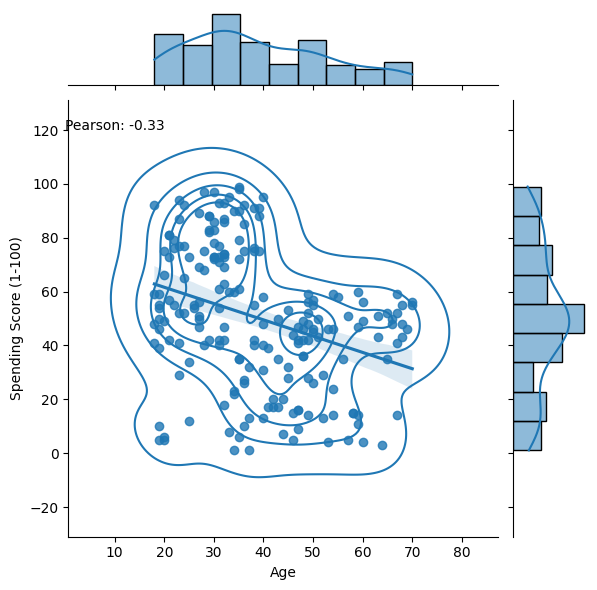

In [15]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

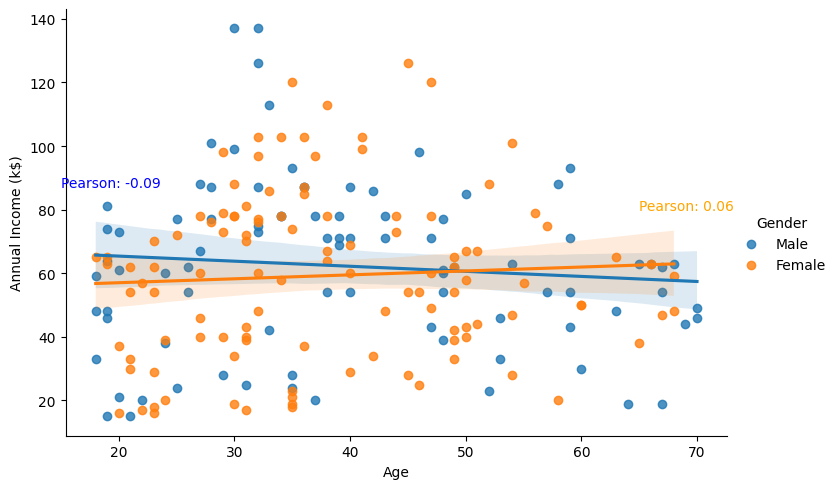

In [16]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

=> 두 성별 그룹 모두 고객의 나이와 연간 소득 사이에는 무시할 수 있는 상관관계가 있다

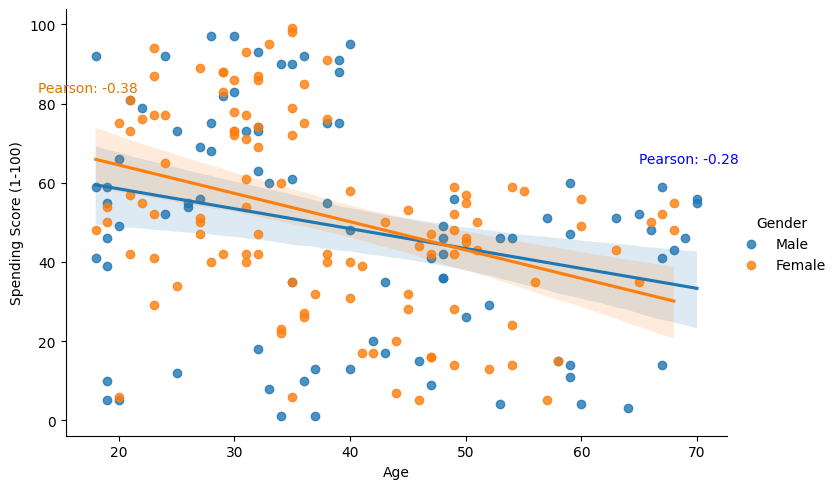

In [17]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

=> 두 성별 그룹의 연령과 지출 점수 사이에는 주별 음의 상관 관계가 있다

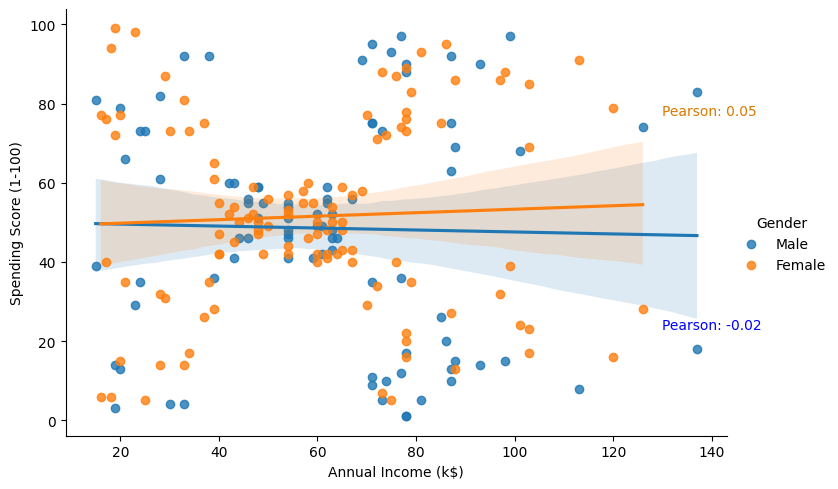

In [18]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

=> 두 성별 그룹의 연간 소득과 소비 점수 사이에는 무시할 수 있는 상관관계가 있다

# 4. Clustering

* 3개의 군집 알고리즘
  + K-Means
  + Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
  + Affinity Propagation

## 4.1 K-Means



### 4.1.1 Description

가장 잘 알려진 분할 군집 알고리즘 = K-평균(Lloyd's algorithm)

* 3가지 주요 단계
  + 1. seed points를 사용하여 샘플을 초기 그룹으로 나눈다. 이 seed points에서 가장 가까운 샘플으로 초기 군집을 만든다.
  + 2. 그룹의 중심점까지의 표본 거리를 계산하고 가장 가까운 표본을 군집에 할당한다.
  + 3. 새로 생성된 군집 중심을 계산한다.
  + 알고리즘이 수렴될 때까지 2번과 3번 과정을 반복한다.

* 목표 = 모든 군집에 대한 목적 함수 최소화하는 것

* NP-hard 문제. greedy algorithm. local minimum으로 수렴된다는 것
* 계산 비용 = O(kn)
  + k : 군집의 수
  + n : 표본의 수

* 일반적으로 local minimum으로 수렴함에도 불구하고, 상대적으로 빠르며, 그룹이 서로 잘 분리되면 global minimum으로 수렴할 가능성이 높다
* 군집화 결과는 초기화 기준에 따라 달라 -> 다양한 초기화 지점에 대한 분석을 실행하고 관성이 최소인 지점을 선택하는 것이 일반적

* 3개의 주요 파라미터
  + 1. Initialisation criteria
    - "k-means++" : 일반적으로 서로 떨어져 있는 초기 중심을 생성하여 더 나은 결과를 얻을 확률을 높인다
  + 2. Number of clusters
    - 다수의 클러스터를 선택하는 방법 -> 엘보 방법. 실루엣 점수.(+MML, MDL, BIC, AIC 등)

### 4.1.2 Use case - customers segmentation

In [19]:
from sklearn.cluster import KMeans 

In [20]:
# subset with numeric variables only(gender 제외)
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

* 적절한 수의 군집 수 찾기 위해 -> **the elbow method** 사용
  + 그래프에서 a kink이나 "an elbow"가 보이는 곳의 클러스터 수 선택

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

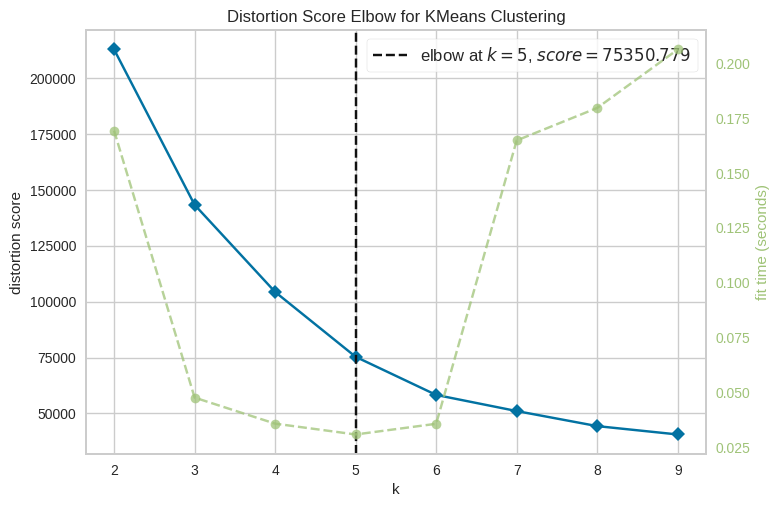

In [21]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

=> 군집 수가 증가함에 따라 왜곡 점수가 감소. 명확한 "elbow" 보이지 않아. 기본 알고리즘은 5개의 군집 제안. 5개 또는 6개의 군집 선택하는 것 공정.

* 군집 수 함수로 **silhuette score** 표시

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

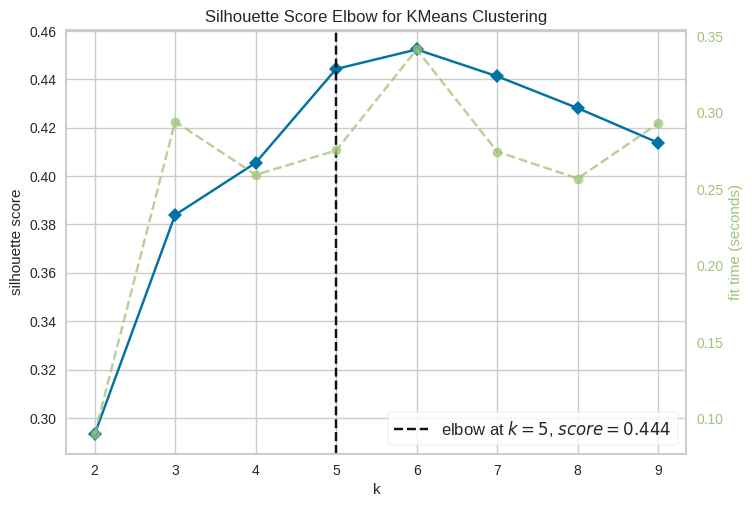

In [22]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

=> 최적의 옵션이 5개 또는 6개의 군집. 둘 다 비교

* <5 Clusters>

In [23]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


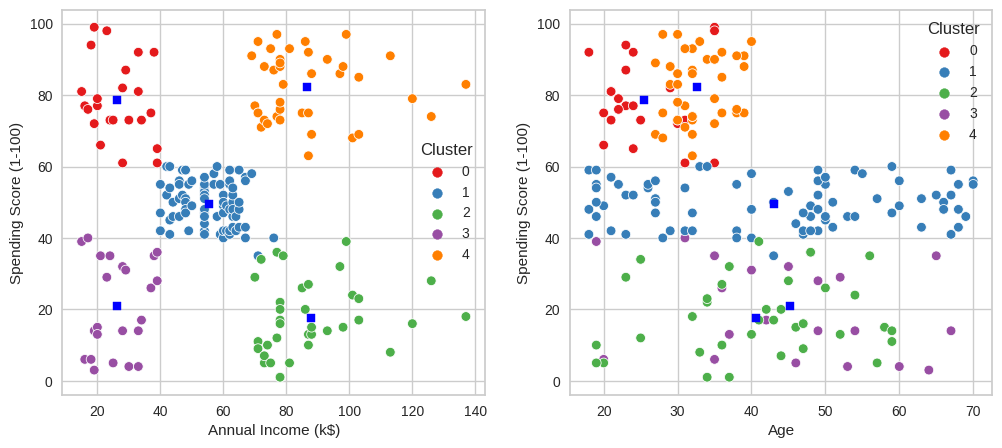

In [24]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()


=> 5개의 군집 생성
> * clients with low annual income and high spending score
* clients with medium annual income and medium spending score
* clients with high annual income and low spending score
* clients with high annual income and high spending score
* clients with low annual income and low spending score

고객 연령에 따라 구분되는 그룹은 x

* clusters 크기

In [25]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,79
2,36
3,23
4,39


=> 가장 큰 군집은 관측치가 79개인 군집 번호 1. 각각 23개의 관측치를 포함하는 가장 작은 관측치 두 개 존재.

In [26]:
# 5개의 생성된 클러스터의 3D 투영
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

<ipython-input-26-a8ca8632ecab>:12: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
<ipython-input-26-a8ca8632ecab>:13: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
<ipython-input-26-a8ca8632ecab>:14: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])
<ipython-input-26-a8ca8632ecab>:19: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


<Figure size 700x700 with 0 Axes>

In [27]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



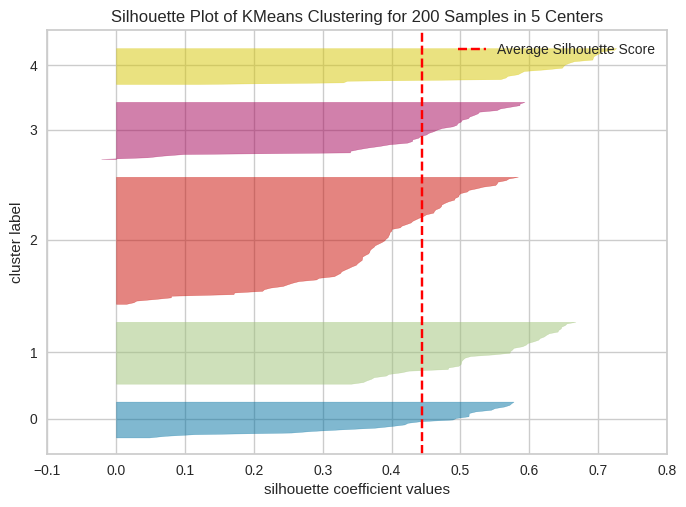

In [28]:
# Silhuette plot
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

* <6 Clusters>

In [29]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



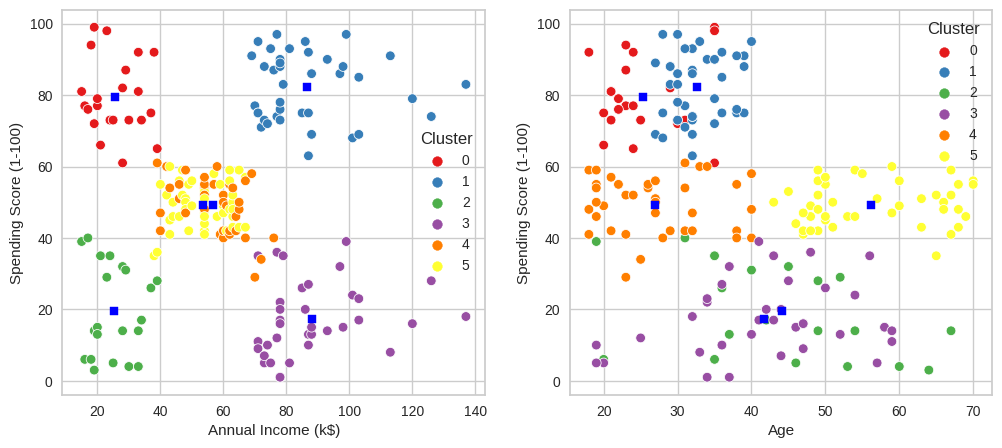

In [30]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

=> 6개의 군집 생성
> * younger clients with **medium** annual and **medium** spending score
* clients with **high** annual income and **low** spending score
* younger clients with **medium** annual and **medium** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score
* clients with **low** annual income and **high** spending score

고객 연령에 따라 구분되는 그룹은 x

In [31]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,22
1,39
2,21
3,35
4,38
5,45


In [32]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



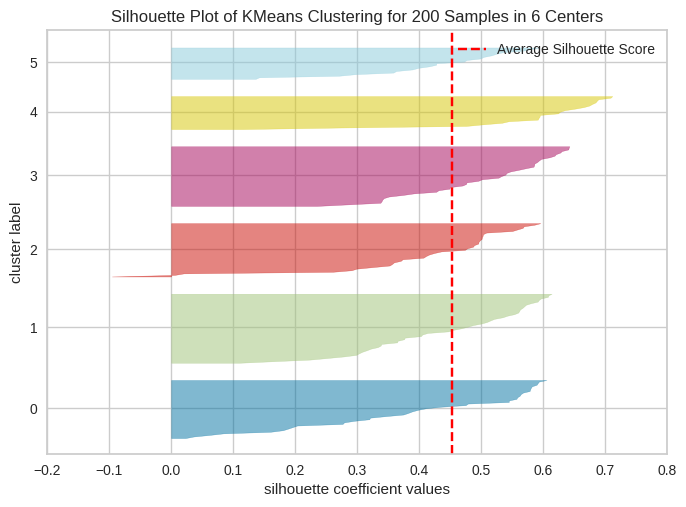

In [33]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

## 4.2 DBSCAN

### 4.2.1 Description

**DBSCAN** : 노이즈가 있는 애플리케이션의 밀도 기반 공간 클러스터링. 사이킷런 라이브러리에 구현된 클러스터링 알고리즘

* 핵심 아이디어는 밀집된 지역의 개념을 중심으로 -> 자연 군집이 밀집된 점으로 구성되어 있다는 것

* 두 가지 파라미터
  + Eps, 엡실론 - distance
  + MinPts - 거리 Eps 내에서의 점들의 최소 개수

* 선택적으로 distance metric은 사용자가 지정할 수 있지만, 일반적으로 유클리드 거리 구현

* "밀도 영역"은 모든 점 사이의 거리 내의 최소 점 수 Eps에 의해 생성
  + 이 거리 내에 있지만 다른 최소 포인트 수에 가깝지 않은 포인트는 "경계 포인트"로 처리
  + 나머지는 노이즈 또는 특이치

* 장점
  + eps 및 MinPts 파라미터를 기반으로 클러스터 수 자체를 찾아
  + 클러스터가 항상 볼록한 K-평균과 반대로 길쭉한 클러스터나 다른 클러스터로 둘러싸인 클러스터를 구별할 수 있어
  + 어떤 군집에도 적합하지 않은 점을 찾을 수 있다 - 특이치 탐지

* 단점
  + 평균 O(nlog(n))의 높은 계산 비용
  + 밀도가 다양한 클러스터를 제대로 식별하지 못함

### 4.2.2 Use case - customers segmentation



In [34]:
from sklearn.cluster import DBSCAN

* 두 주요 하이퍼파라미터 **eps**, **min_samples**

In [35]:
# create a matrix of investigated combinations
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [36]:
# 생성된 클러스터 수 확인
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

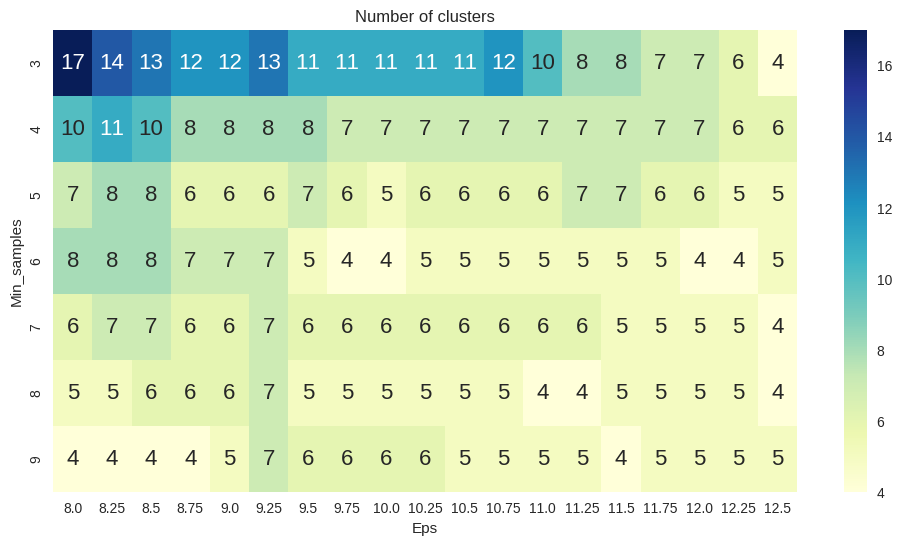

In [37]:
# heatplot -> 각 파라미터 조합에 대해 DBSCAN 알고리즘에 의해 생성된 군집 수
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

=> 군집의 수가 17개에서 4개까지 다양하다는 것. 대부분의 조합은 4-7개의 군집 제공

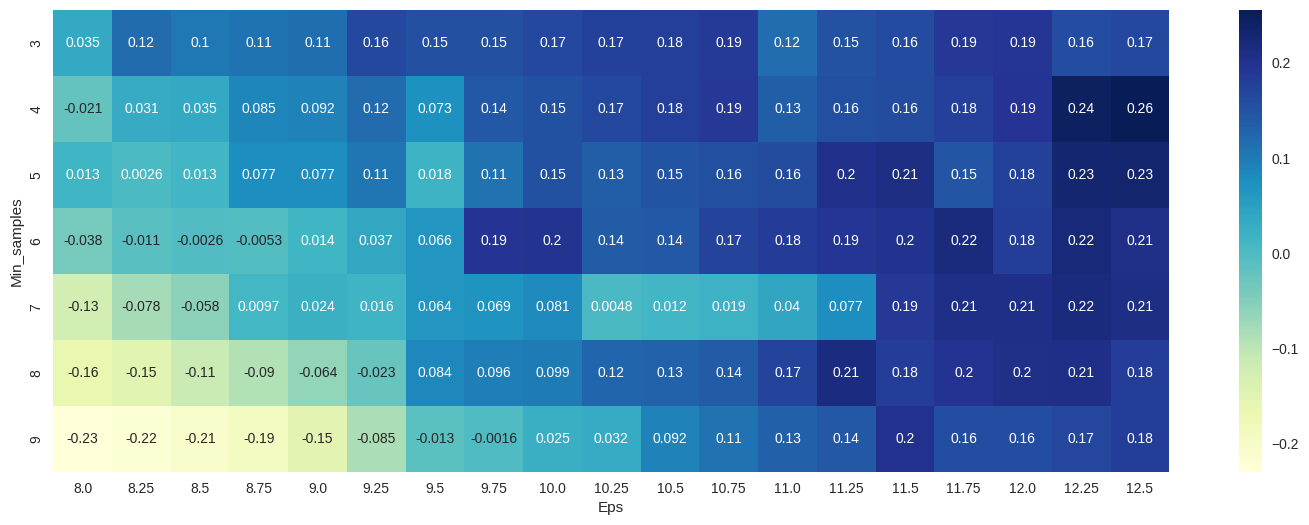

In [38]:
# 실루엣 점수 사용. 히트맵으로 다시 plot
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

=> eps=12.5, min_samples=4일 때 global maximum=0.26

In [39]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [40]:
# 클러스터 크기 확인
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


=> 5개의 군집과 특이치 군집(-1) 생성. 0-4 군집의 크기는 유의하게 달라. 일부 군집은 관측치가 4개 또는 8개뿐. 특이치는 18개.

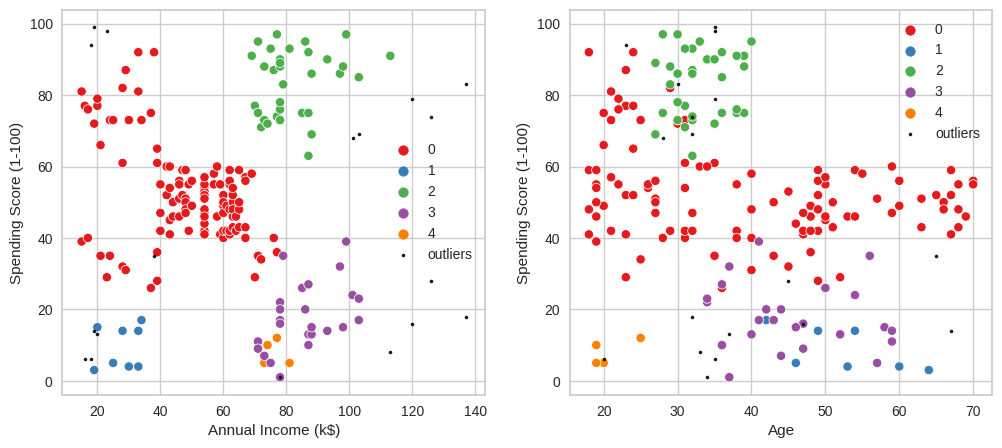

In [42]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

=> 특이치 있음. 군집으로 인식되는 거리 및 최소 표본 요구사항 충족x.

## 4.3 Affinity Propagation

### 4.3.1 Description

**Affinity Propagation** : 한 쌍의 포인트 간에 메시지가 수렴될 때까지 메시지를 보내는 개념을 기반으로 해. 이 두 지점이 서로 얼마나 유사한지 측정하는 방법. 최적의 군집 수 자체를 찾아

* O(n^2T)의 매우 높은 시간 복잡도 비용 의미
  + n: 샘플의 수
  + T: 수렴할 때까지의 반복 횟수

* 장점 : 초기화 기준에 대한 민감도가 낮다는 것

* 두 파라미터
  + 음수이고 사용되는 에제 수를 제어하는 선호도
  + 메시지 업데이트 시 수치 진동을 방지하는 감쇠 계수

### 4.3.2 Use case - customers segmentation

In [43]:
from sklearn.cluster import AffinityPropagation

In [44]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


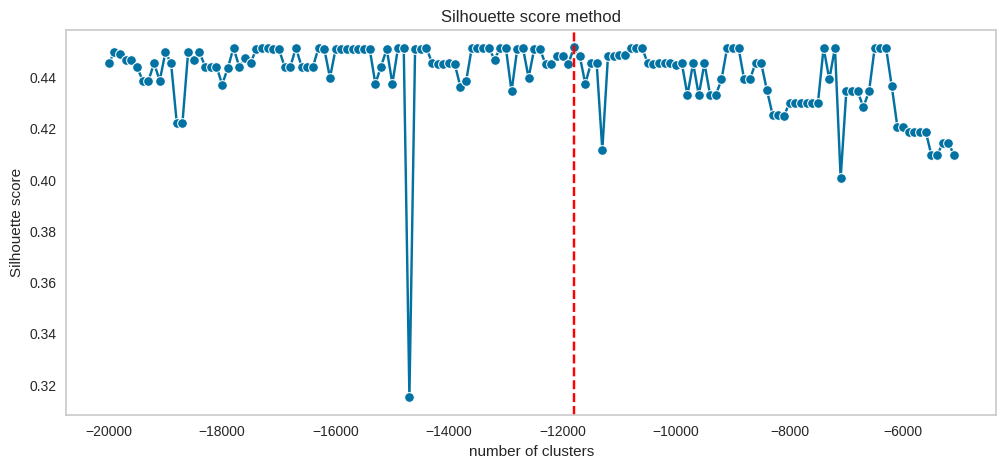

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [47]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [48]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [49]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


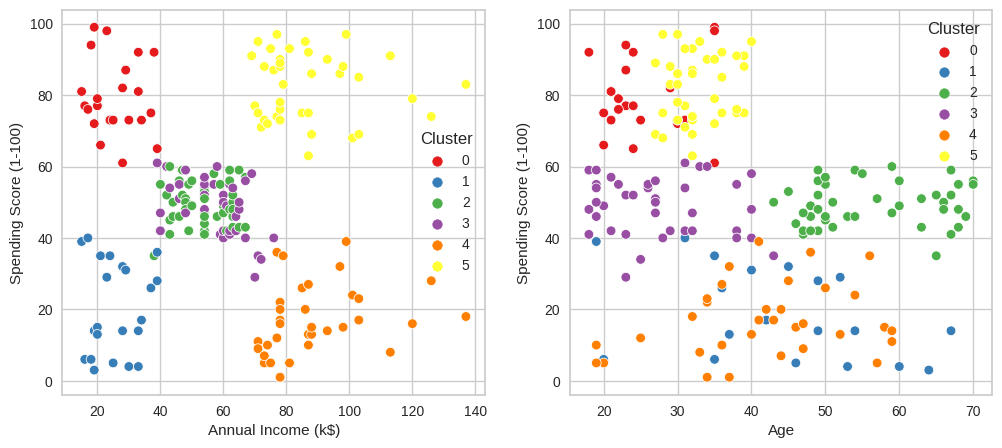

In [52]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

=> Affinity Propagation 알고리즘에 의해 생성된 군집은 K-평균에 의해 생성된 군집과 유사한 비교적 고른 크기의 군집 생성

# 5. Comparison and discussion

3가지 알고리즘 비교

* K-Means

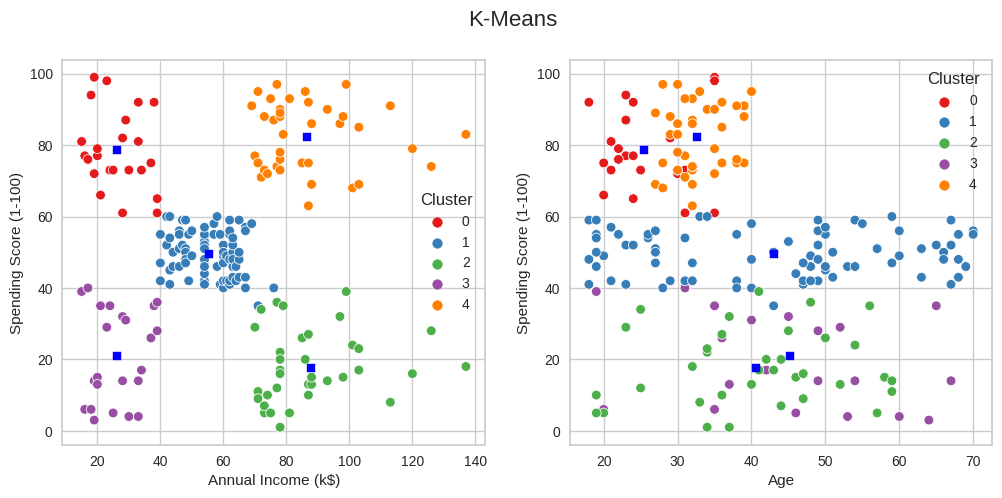

In [53]:
# 클러스터 5개
fig1.suptitle('K-Means', fontsize=16)
fig1

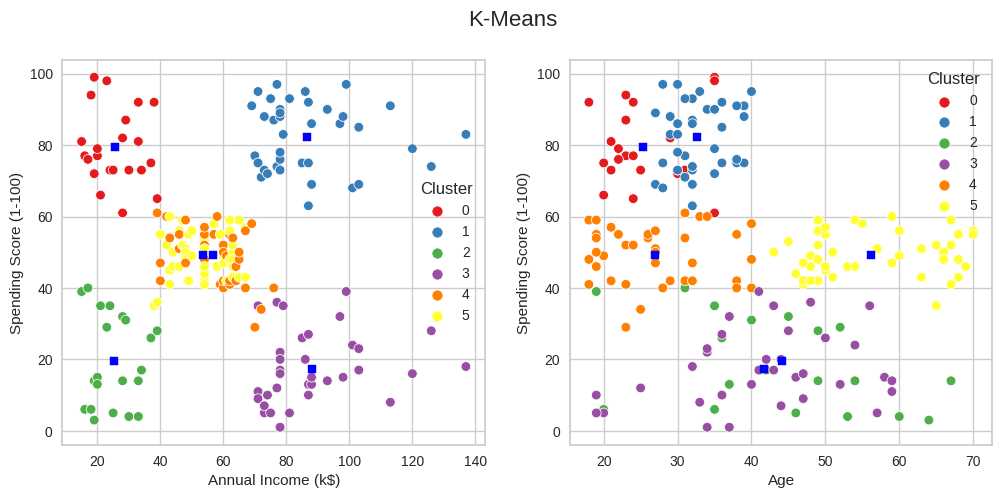

In [54]:
# 클러스터 6개
fig11.suptitle('K-Means', fontsize=16)
fig11

* DBSCAN

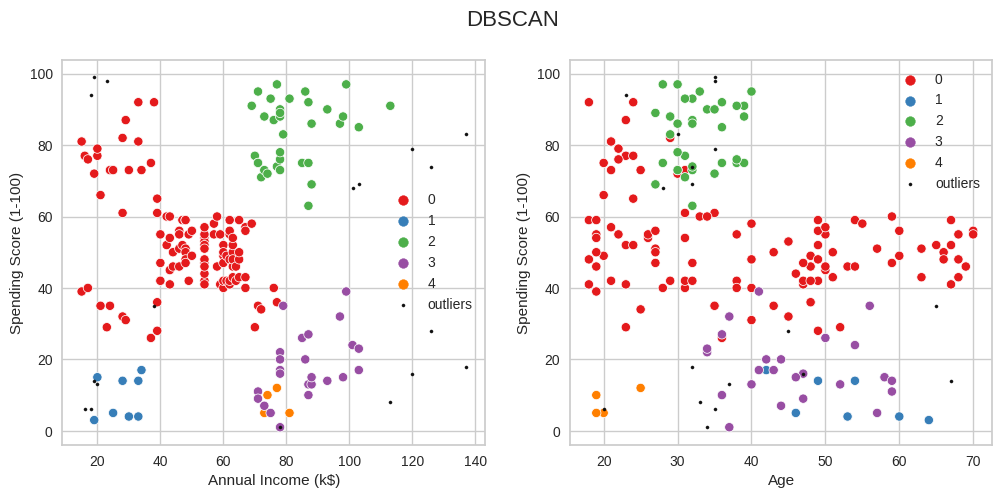

In [55]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

* Affinity Propagation

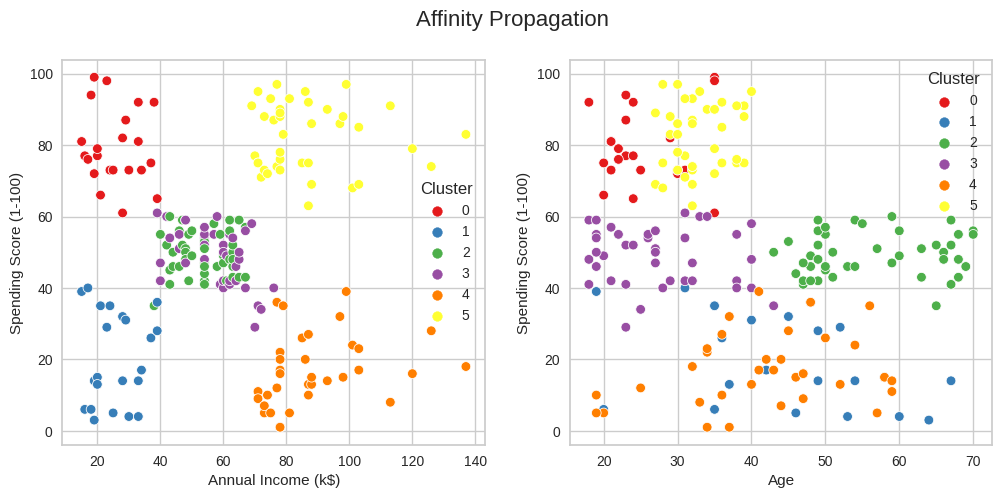

In [56]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

=> 아래 표에는 생성된 클러스터의 크기. 클러스터 번호 지정은 각 방법마다 달라

In [57]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,22.0,112.0,22.0
1,39.0,8.0,22.0
2,21.0,34.0,44.0
3,35.0,24.0,39.0
4,38.0,4.0,34.0
5,45.0,NaN,39.0
-1,NaN,18.0,NaN


=> DBSCAN이 합리적인 클러스터 생성하는 데 실패. DBSCAN은 점의 밀도를 기반으로 군집 찾으려 하기 때문일 가능성 높아. 어떤 클러스터가 다른 클러스터보다 밀도가 낮은 경우, DBSCAN은 클러스터로 인식하지 않음으로써 차선의 결과 생성.

차례로, K-평균 및 Affinity Propagation 알고리즘은 합리적인 6개의 군집 만들었음.